# PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

## Tutorial 2: Process Level Modelling (15-20 minutes)

## Process level

Recall that we introduced the basic theories about hierachical modelling of sea-level in last tutorial, in summary it can be represented as:

<img width=700px src="Hierachical_framework.png"/>

We've covered data level modelling in the last notebook, so in this tutorial, we will go through the `process level modelling' which is often the most important section for sea-level modelling research.


The process level is hierarchical level at which the variability of sea-levle change is modeled and in some cases, decomposed based on data model. The process level reflects our understandings of sea-level change processes. For simplicity, we introduce process level for modelling temporal sea-level processes here, but it can be easily extended to a higher dimension (e.g., spatio-temporal). Some typical methods used for represent process level of sea-level change are (we will go through each of them in this tutorial):

&#10148; **1. Any kind of hand-drawn curve:** Intuitively draw a curve to fit the observational data by hand. An example below from [Zong 2004](https://www.sciencedirect.com/science/article/pii/S1040618203001162?casa_token=hduIZdtNm-QAAAAA:hlPhRyw9NWqKl7pz3oakuR6K1JiVyAbhukAZshFbOMLGGg0jhAVuomutQdkDUOgolnSgfixwSQ) shows hand-drawn RSL curves for Southeast China during Holocene

<img width=800px src="Drawn_RSL.png"/>


&#10148; **2. Linear/polynomial model:** Assuming sea-level changes based on a certain kind of polynomial function (i.e., first-order polynomial equals temporally linear model, second-order polynomial can introduce a further parameter to control the rate of RSL change; acceleration/deceleration, etc...). An example below from [Lin et al., 2021](https://www.nature.com/articles/s41467-021-21990-y) assumes RSL change linearly during [Meltwater Pulse 1A](https://en.wikipedia.org/wiki/Meltwater_pulse_1A).

<img width=800px src="MWP_RSL.png"/>

&#10148; **3. Change-point model**: An extention of linear/polynomial model where a change-point model identifies points in the data where the rate of sea-level change can be significantly differnet before and after these points. An exmaple below from [Lambeck et al., 2014](https://www.pnas.org/doi/abs/10.1073/pnas.1411762111) uses a change point model approach to reconstruct global ice-equivalent sea-level from the 35 ka BP to present. 

<img width=800px src="ESL.png"/>

&#10148; **4. Gaussian Process model**: An nonparametric and Bayesian approach, to infer temporal variation of sea-level change based on covariance matrix estimated conditional upon the data. Compared to using other parametric models (e.g., polynomial, change-point model) to infer time series, GP time-series models have much more flexibility. An example below from [Tan et al., (2022)](https://www.sciencedirect.com/science/article/pii/S0277379123000434#fig3) shows relative sea-level change estimated based on a Gaussian Process modern conditioned on RSL data. 

<img width=400px src="GP_RSL.png"/>


&#10148; **5. Physical model**: RSL is predicted by the physical governing equations and specific physical parameters, such as ice history and Earth rheology for a glacial isostatic adjustment (GIA) model. An example below from [Simon et al., 2022](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JB023693) shows different GIA model predictions in comparison to RSL data. 

<img width=800px src="Physical_RSL.png"/>

&#10148; **6. Mixed physical and statistical model or data assimilation**: This approach combined physical model with observational data (which can be represented by statistical models) to improve the accuracy and  reliability of predictions. An exmaple below from [Creel et al., 2022](https://www.sciencedirect.com/science/article/pii/S0277379122000531?casa_token=pY88KBJVoMgAAAAA:tlgDNf7iZ5hOKiPY9L5b5eA-Q_XMhlYtDSaBDjPZMdNjDPb1Kw3uaeRPp6ayyaijXn4EytwzOw#fig3) used an ensemble of GIA model to predict RSL at time and location where RSL data located at with different physical parameter combinations, they then update those physical model preidctions using a Guassian Process appraoch.

<img width=800px src="Norwary_RSL.png"/>

## Parameter Level

The parameter level captures key attributes of the data and process levels through unobserved parameters, which can be physical or statistical parameters. With parameter level model, we can reflect our prior knowledge on the final prediction. For example, if we are using a Gaussian Process model to infer sea-level change rate, an important hyperparameter we need to define is length scale. If we have no idea whether sea-level change in your sites will be short-wavelength or long-wavelenth, we can set a non-informative prior to this hyperparameter. However, if we have some ideas about how sea-level may change here, commonly from physical insights, we can set the lengthscale to a certain plausible range. 


## Illustrative example: New Jersey sea-level trend and rate modelling

To illustrate different process level models and see their difference in prediction performances, we will use real sea-level data from New Jersey ([Kemp et al., 2013](https://www.sciencedirect.com/science/article/abs/pii/S0277379113003740)), which contains 135 sea-level data points each with: reconstructed RSL, age, RSL reconstructeion uncertainty and age uncertainty. The data model used here assumes age and RSL are both distributed normally. Let's check the data first. Note, we will now start to use PaleoSTeHM module (PSTHM), which contains python functions to load/plot data, create/optimize statistical model.  

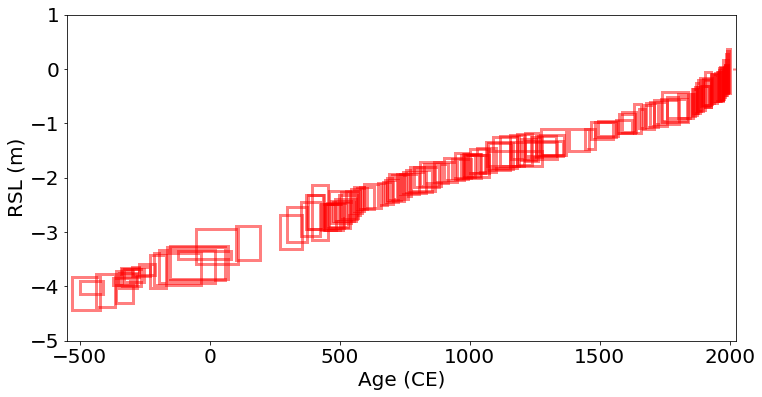

In [1]:
import sys
sys.path.append('../../Code')
import PSTHM 
import numpy as np
import torch 
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import warnings
from scipy import interpolate

warnings.filterwarnings("ignore")
#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)

#load data 
X,y,y_sigma,x_sigma,lon,lat = PSTHM.load_local_rsl_data('../../Data/NJ_CC.csv')
X,X_index = torch.sort(X)
y = y[X_index]
y_sigma = y_sigma[X_index]
x_sigma = x_sigma[X_index]
lon = torch.tensor(lon)[X_index]
lat = torch.tensor(lat)[X_index]
#visualize data
ax = PSTHM.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2)
ax.set_xlim(-550,2025)
ax.set_ylim(-5,1)
plt.show();

Remember that we assume both the RSL and age model to be normally distributed, as plotting their 2D distribution will be pretty noisy and hard to see, we plot 2-sigma uncertainty box instead. And we can start to test different process level models on it. And we will define model performances by weighted mean squared error (wMSE), the weighting factor for each data point is its vertical 1-sigma uncertainty. 

### 1. Hand-drawn curve

It seems to me that sea-level rose constantly from -500 to 1200 CE. After that sea-level rise rate slightly dropped until 1800 when sea-level started to rise much more rapidly. I can generate my intuitive curve by setting several points and link them. 

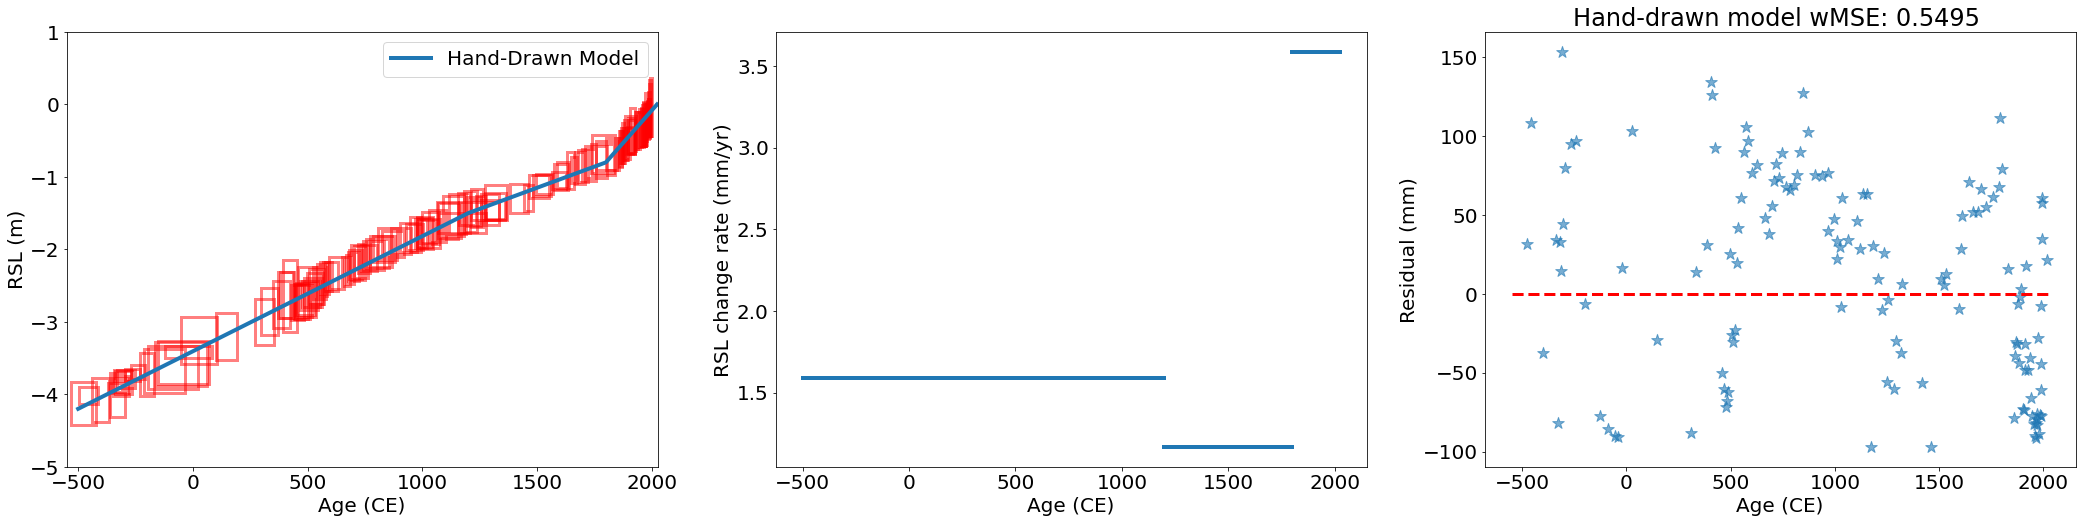

In [2]:
from scipy import interpolate
hand_model_x = [-500,1200,1800,2023]
hand_model_y = [-4.2,-1.5,-0.8,0]

#--------visualize modelled RSL, RSL change rate and model residual-----------------
plt.figure(figsize=(36,8))
ax = plt.subplot(131)
PSTHM.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,ax=ax)
plt.plot(hand_model_x,hand_model_y,color='C0',linewidth=4,label='Hand-Drawn Model')
ax.set_xlim(-550,2025)
ax.set_ylim(-5,1)
plt.legend()

ax2 = plt.subplot(132)
hand_model_rate = np.diff(hand_model_y)/np.diff(hand_model_x)*1000
for i in range(len(hand_model_rate)):
    plt.plot([hand_model_x[i],hand_model_x[i+1]],[hand_model_rate[i],hand_model_rate[i]],color='C0',linewidth=4)
plt.ylabel('RSL change rate (mm/yr)')
plt.xlabel('Age (CE)')

ax3 = plt.subplot(133)
f_hand = interpolate.interp1d(hand_model_x,hand_model_y)
hand_prediction = f_hand(X)
plt.scatter(X,(y.detach().numpy()-hand_prediction)*1000,s=150,marker='*',color='C0',alpha=0.6)
plt.hlines(0,-550,2025,linestyle='--',color='r',lw=3)
plt.xlabel('Age (CE)')
plt.ylabel('Residual (mm)')
plt.title('Hand-drawn model wMSE: {:4.4f} '.format(PSTHM.cal_wMSE(y.detach().numpy(),hand_prediction,y_sigma.detach().numpy())))
plt.show()



We can see that the hand-drawn model is actually doing a great job, so for this problem, human intuition do provides some insights. And let's try other process models.

### 2. Linear/polynomial model

For a linear model, the process level of temporal sea-level change can be written as:
$$
f_{linear}(\overline{t}_{i}) = \overline{t}_{i} \times a + b\\
$$
where $a$ is a sea-level rise rate coefficient, $b$ is a intercept coefficient, indicating sea-level when time is 0. Intergrate this parameter level model with data level model we get:

$$
y = f_{linear}(\overline{t}_{i}) + \epsilon_{i}\\
  =  \overline{t}_{i} \times a + b + \epsilon_{i}\\
$$
where:
$$
t_{i}  = \overline{t}_{i} +\delta_{i}
$$
And lastly, for a Bayesian model, very parameter is represented by a PDF instead of a single value, therefore, we need to define a prior distribution fo $a$ and $b$, which reflects our prior understandinging of them. And this is so called **parameter level model**. And for New Jersey data, I don't have too much information of how sea-level will change, so I assign non-informative prior to my parameter level:
$$
a \sim U(-0.01,0.01)\\
b \sim U(-5,5)
$$
which means I assume sea-level rise rate in this sites should be between -10 mm/yr and 10 mm/yr, and local sea-levle should sit between -5 m and 5 m, which are pretty safe assumptions. Of course, if you have a good knowledge of a prior parameter distribtuions (e.g., from field and lab observations), you can set a informative prior to reflect those knowledge, and the resulting posterior distribution will be a mixture of your prior knowledge and the model-data comparison (i.e, likelihood function). A full list of distributions pyro support can be found [here](https://docs.pyro.ai/en/stable/distributions.html). Let's visulize some of commonlu-used prior here:


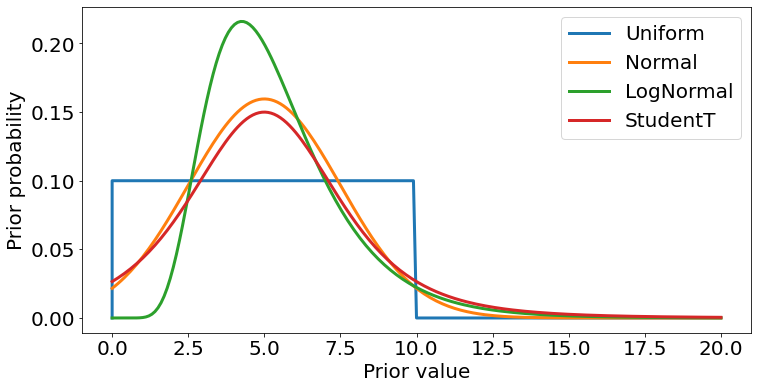

In [3]:
import pyro.distributions as dist
test_value = torch.linspace(1e-5,9.9,200)
test_value2 = torch.linspace(1e-5,20,200)

uniform_prior = dist.Uniform(0,10).log_prob(test_value).exp()
normal_prior = dist.Normal(5,2.5).log_prob(test_value2).exp()
lognormal_prior = dist.LogNormal(np.log(5),0.4).log_prob(test_value2).exp()
studentt_prior = dist.StudentT(df = 4,loc=5,scale=2.5).log_prob(test_value2).exp()
uniform_prior = torch.cat((torch.zeros(1),uniform_prior,torch.zeros(2)))
test_value =  torch.cat((torch.zeros(1),test_value,torch.ones(1)*10,torch.ones(1)*20))

plt.plot(test_value,uniform_prior,label='Uniform',lw=3)
plt.plot(test_value2,normal_prior,label='Normal',lw=3)
plt.plot(test_value2,lognormal_prior,label='LogNormal',lw=3)
plt.plot(test_value2,studentt_prior,label='StudentT',lw=3)
plt.xlabel('Prior value')
plt.ylabel('Prior probability')
plt.legend();


Once we satisfy with the prior distributions of each parameter, we can write our hierarchical model together as:
$$
p(f,\epsilon,\delta, a, b|y) \propto p(y|f,\epsilon,\delta) \cdot p(f|a,b) \cdot p(\epsilon,\delta, a, b)
$$
Ok, now we have our first hierarchical model, we can now try to run it. Now we will start to use PaleoSTeHM API, which is built upon pyro, the code is fully commented, you can check the source code for more details. For every process/parameter model implementation, there are three general steps:

&#10148; 1. Define the process and parameter models

&#10148; 2. Optimize the parameter models based conditioned upon data model

&#10148; 3. Visulize model outputs


  0%|          | 0/2000 [00:00<?, ?it/s]

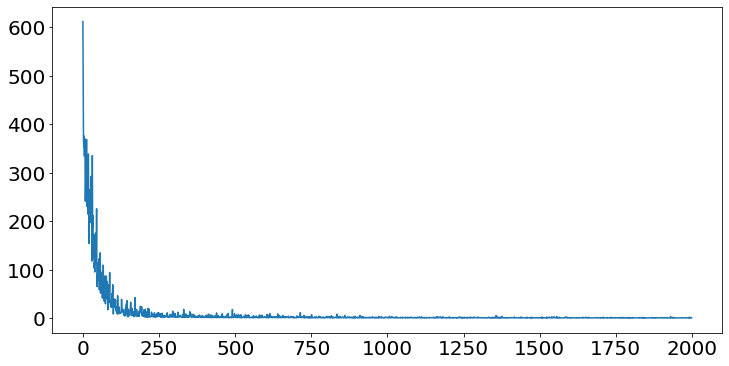

In [4]:
import pyro.distributions as dist

#------Define the process mdoel---------
linear_model = PSTHM.linear_model
test_X = X[:,None] #convert X to a 2D array which is more common for pytorch models
#-------Define parameter model---------
#you can change the prior distribution here to see how it affects the model!
intercept_prior = dist.Uniform(-5., 5.)
coefficient_prior = dist.Uniform(-0.01,0.01)
#-------Optimize parameter model---------
guide,losses = PSTHM.opti_pyro_model(linear_model,test_X,y,x_sigma,y_sigma,intercept_prior,coefficient_prior,lr=0.02)
#-------Visualize the training loss---------
plt.plot(losses);

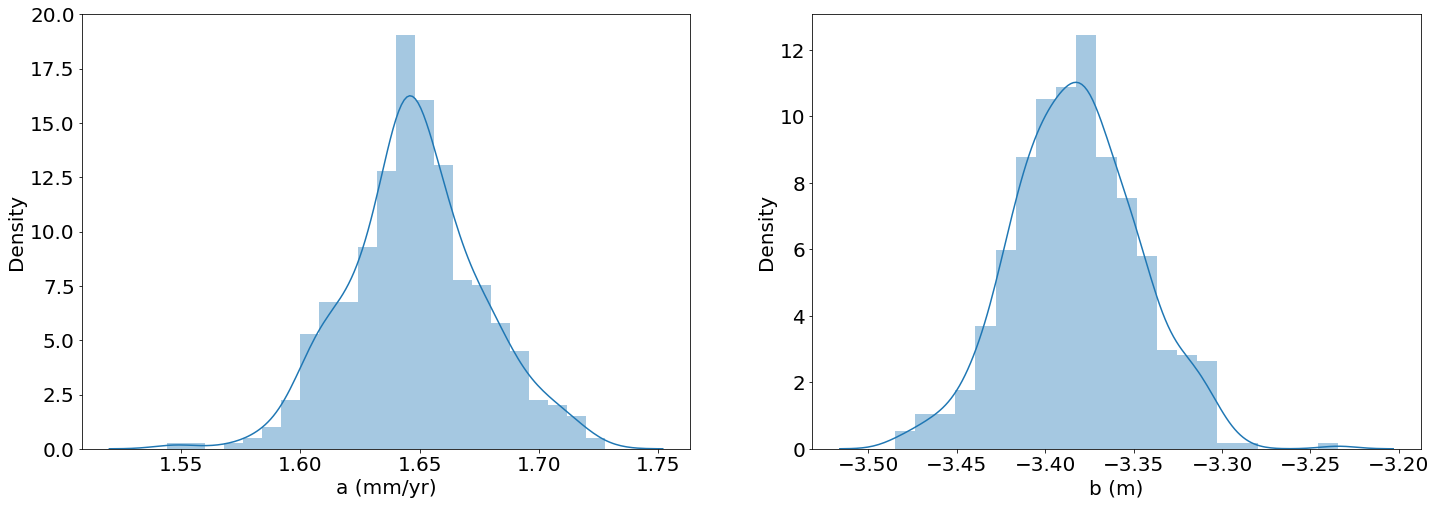

In [5]:
#-------Visualize the optimized model---------
#estimate the posterior distribution of the model parameters from optimized model 
pred_x = torch.tensor([-500,2023])
sample_number = 500 #number of samples to draw from the posterior distribution
a_dis,b_dis,y_pred = torch.zeros(sample_number),torch.zeros(sample_number),torch.zeros(sample_number,len(pred_x))
for i in range(sample_number):
    test_b,test_a,_ = guide().values()
    y_pred[i] = pred_x*test_a + test_b
    a_dis[i] = test_a
    b_dis[i] = test_b
y_pred = y_pred.detach().numpy()
a_dis = a_dis.detach().numpy()
b_dis = b_dis.detach().numpy()

#-------Visualize the posterior distribution of the model parameters---------
plt.figure(figsize=(24,8))
plt.subplot(121)
sns.distplot(a_dis*1000,axlabel='a (mm/yr)')
plt.subplot(122)
sns.distplot(b_dis,axlabel='b (m)');

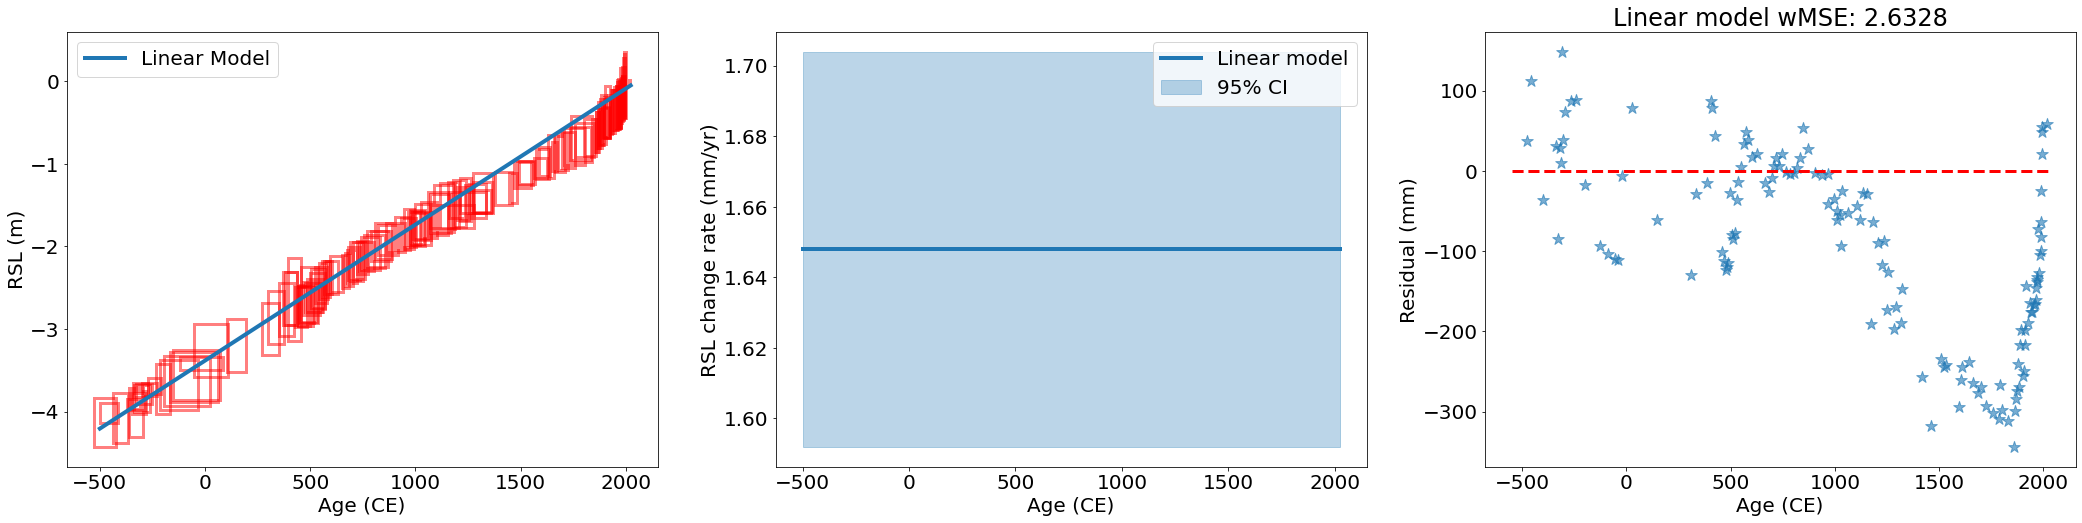

In [6]:
a_mean,a_std = np.mean(a_dis),np.std(a_dis)
b_mean,b_std = np.mean(b_dis),np.std(b_dis)
mean_pred = np.mean(y_pred,axis=0)

#--------visualize modelled RSL, RSL change rate and model residual-----------------
plt.figure(figsize=(36,8))
ax = plt.subplot(131)
PSTHM.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,ax=ax)
plt.plot(pred_x,mean_pred,color='C0',linewidth=4,label='Linear Model')
# ax.set_xlim(-550,2025)
# ax.set_ylim(-5,1)
plt.legend()

ax2 = plt.subplot(132)
plt.plot(pred_x,[a_mean*1000,a_mean*1000],color='C0',linewidth=4,label='Linear model')
plt.fill_between(pred_x,(a_mean-2*a_std)*1000,(a_mean+2*a_std)*1000,color='C0',alpha=0.3,label='95% CI')
plt.ylabel('RSL change rate (mm/yr)')
plt.xlabel('Age (CE)')
plt.legend()

ax3 = plt.subplot(133)
f_linear= interpolate.interp1d(pred_x,mean_pred)
linear_prediction = f_linear(X)
plt.scatter(X,(y.detach().numpy()-linear_prediction)*1000,s=150,marker='*',color='C0',alpha=0.6)
plt.xlabel('Age (CE)')

plt.ylabel('Residual (mm)')
plt.title('Linear model wMSE: {:4.4f}'.format(PSTHM.cal_wMSE(y.detach().numpy(),linear_prediction,y_sigma.detach().numpy())))
plt.hlines(0,-550,2025,linestyle='--',color='r',lw=3)

plt.show()



Now, you can see that instead of a single estimate of RSL trend and rate by a hand-drawn model, we are now able to infer posterior distributions of process model paraemters (sea-level rise rate and intercept coefficients) and of sea-level change trend and rate (so-called the Bayesian model). Therefore, we can start to quantify the uncetaitny of each parameter and prediction results.

However, the Bayesian method does not guarantee a better prediction performance as you can see here the MSE for this Bayesian model is actually higher than the hand-drawn model and the residual looks much more structed as well (a good performance should present residuals with no temporal structure with near stationary distribution). Instead, the process model choice usually has more impact on model performance, so have good a think about which model fits the best for yoru own problem. 

Based on the wMSE and residual structure above, we found that assuming a single sea-level rise rate in New Jersey is not a good choice. So instead of using a single RSL rate for the whole period, we can use one multiple rates for different periods, the change-point model.


### 3. Change-point model

The change-point model is a popular process model to infer time series data because it can not only infer the rate of change in different periods of time but also when the rate is chaning, a very handy property for inferring abrupt change in sea level and climate science (see examples like [Caesar et al., 2021](https://www.nature.com/articles/s41561-021-00699-z)). This change-point model we used here is based on a [change-point modelling blog](https://www.niamhcahill.com/post/cptutorial/) by Niamh Cahill.  

The change point model separates the whole time period into seveal partitions where each partition has its own sea-level change rate. It is possible assign the number of change points (e.g., [Cahill et al., 2015](https://iopscience.iop.org/article/10.1088/1748-9326/10/8/084002)) or we can let the data itself to infer the number of change point (e.g., [Sambridge 2016](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JB012901)). Here we will use the former model and so you can assign the number of change-point ($j$) you want to use. In this case, the parameters here we try to infer are change-point locations ($\Iota$) and its uncertainty ($\sigma_{\Iota}$):
$$
\Iota = [\iota_{1},\iota_{2}...\iota_{j}]\\
\sigma_{\Iota} = [\sigma_{\iota_{1}},\sigma_{\iota_{2}}...\sigma_{\iota_{j}}]
$$  
sea-level change rate at different partitions ($A$) and its uncertainty ($\sigma_{A}$):

$$
A = [a_{1},a_{2}...a_{j+1}]\\
\sigma_{A} = [\sigma_{a_{1}},\sigma_{a_{2}}...\sigma_{a_{j+1}}]
$$
and intercept of initial points ($b_{1}$), indicating sea level at oldest age of observational data ($t_{min}$,here is -476). Note the definition of $b_{1}$ here is different to $b$ in a linear model.

In this case, this change-point model can be expressed as:

$$
f_{cp}(t_{i}) = b_{1} + a_{1}(t_{i} -t_{min}) \;\;\;\;\; if \;\; t_{i} \leq \iota_{1} \\ 
f_{cp}(t_{i}) = b_{2}+ a_{2}(t_{i} - \iota_{1})  \;\;\;\;\; if \;\; \iota_{1} <t_{i} \leq \iota_{2} \\ 
.\\
.\\
.\\
f_{cp}(t_{i}) = b_{j+1} + a_{j+1}(t_{i} - \iota_{j})\;\;\;\;\; if \;\; \iota_{j} <t_{i}\\ 
$$
where $b_{2}\;...b_{j+1}$ can be calculated by:
$$
b_{2} = b_{1} + a_{1}(\iota_{1}-t_{min})\\
b_{3} = b_{1} + a_{1}(\iota_{1}-t_{min}) + a_{2}(\iota_{2}-\iota_{1})
.\\
.\\
.\\
b_{j+1} = b_{1} +  a_{1} (\iota_{1}-t_{min}  )+ \sum^{j}_{m=2}a_{m}(\iota_{m}-\iota_{m-1}) 
$$

The following figure will give you a better idea of how it works with 2 change points, you can change the number of change points by simply changing the parameter `num_change_points` below:

<img width=500px src="CP_example.png"/>

As for linear model, we need to assign prior distributions for model parameters:
$$
A \sim U(-0.01,0.01)\\
b_{0} \sim(-7,-2)\\
\Iota = [\iota_{1},\iota_{2},...\iota_{j}]\\
\sim N(min(t)+ m \times d ,d)\\
d = (max(t)-min(t))/(j+1)
$$
where $j$ indicates the number of change-points, max(t) and min(t) represent the maximum and minimum value of observational age from data model, and $m$ denotes $m_{th}$ change-point. Taking these together we can express this hierarchical model as:

$$
p(f,\epsilon,\delta, A, b_{0}, \Iota |y) \propto p(y|f,\epsilon,\delta) \cdot p(f| A, b_{0}, \Iota) \cdot p(\epsilon,\delta, A, b_{0}, \Iota)
$$

  0%|          | 0/2000 [00:00<?, ?it/s]

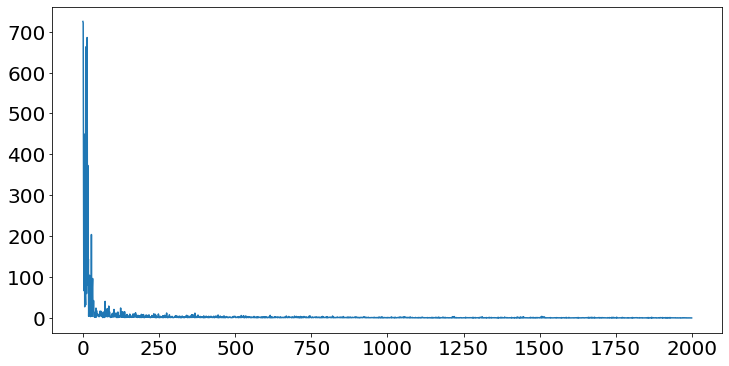

In [7]:
import pyro.distributions as dist

#------Define the process mdoel---------
change_point_model = PSTHM.change_point_model
test_X = X[:,None] #convert X to a 2D array which is more common for pytorch models
#-------Define parameter model---------
intercept_prior = dist.Uniform(-7., -2.)  #prior distribution for b
coefficient_prior = dist.Uniform(-0.01,0.01) #prior distribution for A

num_change_points = 2
guide,losses = PSTHM.opti_pyro_model(change_point_model,test_X,y,x_sigma,y_sigma,num_change_points,intercept_prior,coefficient_prior,lr=0.05,number_of_steps=2000)
#-------Visualize the training loss---------
plt.plot(losses);

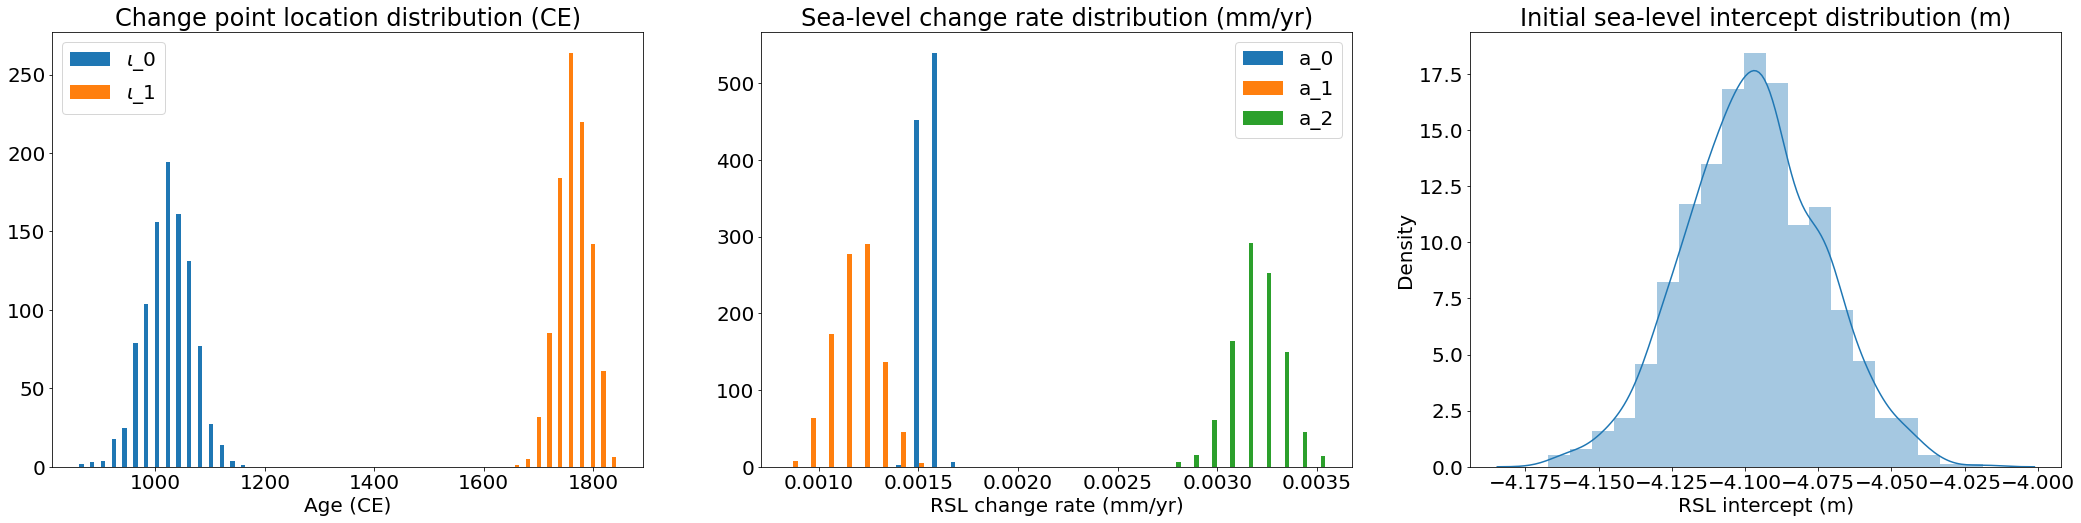

In [8]:
posterior = PSTHM.get_change_point_posterior(guide,1000)

plt.figure(figsize=(36,8))
plt.subplot(131)
plt.hist(posterior['cp'],bins=50,label=[f'$\iota$_{str(i)}' for i in range( posterior['cp'].shape[1])])
plt.xlabel('Age (CE)')
plt.title('Change point location distribution (CE)')
plt.legend()

plt.subplot(132)
plt.hist(posterior['a'],bins=30,label=[f'a_{str(i)}' for i in range( posterior['a'].shape[1])])
plt.xlabel('RSL change rate (mm/yr)')
plt.legend()
plt.title('Sea-level change rate distribution (mm/yr)')

plt.subplot(133)
sns.distplot(posterior['b'],bins=20)
plt.xlabel('RSL intercept (m)')
plt.title('Initial sea-level intercept distribution (m)');

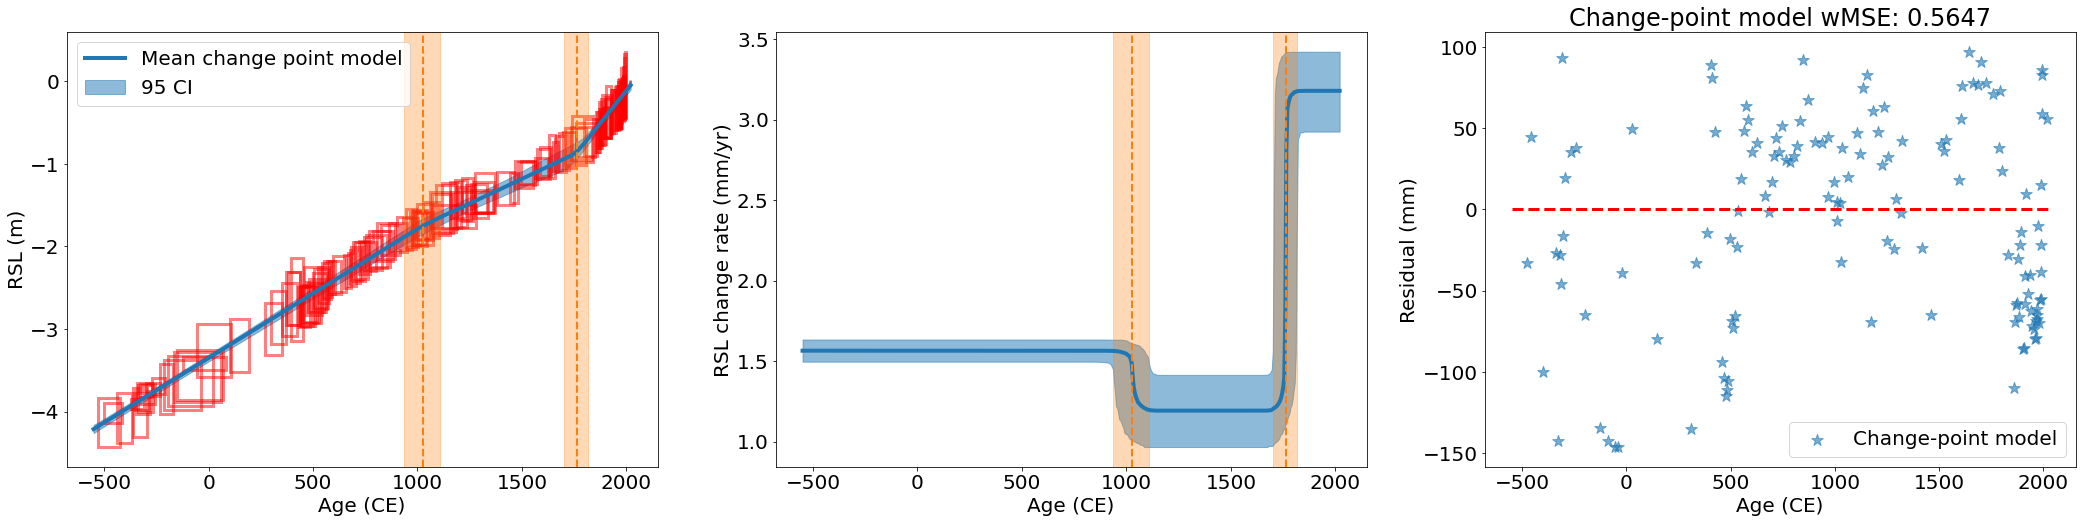

In [9]:
#-------Calculate posterior predictive and sea-level change rate-------
forward_x = torch.arange(-550,2025,5)
change_point_pred = np.zeros([1000,len(forward_x)])
change_point_pred_rate = np.zeros([1000,len(forward_x)])

for i in range(1000):
    change_point_pred[i,:] = PSTHM.change_point_forward(num_change_points,posterior['cp'][i],forward_x[:,None],test_X,posterior['a'][i],posterior['b'][i])
    change_point_pred_rate[i] = np.gradient(change_point_pred[i],forward_x)
change_point_pred_2p5,change_point_pred_50,change_point_pred_97p5 = np.percentile(change_point_pred,[2.5,50,97.5],axis=0)
change_point_pred_rate_2p5,change_point_pred_rate_50,change_point_pred_rate_97p5 = np.percentile(change_point_pred_rate,[2.5,50,97.5],axis=0)*1000
#------------Visualize the change point model----------------
plt.figure(figsize=(36,8))
ax = plt.subplot(131)
PSTHM.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,ax=ax)
plt.plot(forward_x,change_point_pred_50,'C0',linewidth=4,label='Mean change point model')
plt.fill_between(forward_x,change_point_pred_2p5,change_point_pred_97p5,color='C0',alpha=0.5,label='95 CI')

for i in range(posterior['cp'].shape[1]):
    cp_2p5,cp_50,cp_97p5 = np.percentile(posterior['cp'][:,i],[2.5,50,97.5])
    plt.axvline(cp_50,color='C1',linestyle='--',linewidth=2)
    plt.axvspan(cp_2p5,cp_97p5,color='C1',alpha=0.3)
plt.legend()
ax2 = plt.subplot(132)
# plot_time = [X.min(),*posterior['cp'].mean(axis=0),forward_x.max()]
# for i in range(posterior['a'].shape[1]):
#     a_2p5,a_50,a_97p5 = np.percentile(posterior['a'][:,i],[2.5,50,97.5])*1000
#     plt.plot(plot_time[i:i+2],[a_50,a_50],color='C0',linewidth=4)
#     plt.fill_between(plot_time[i:i+2],[a_2p5,a_2p5],[a_97p5,a_97p5],color='C0',alpha=0.3)
plt.plot(forward_x,change_point_pred_rate_50,'C0',linewidth=4,label='Mean change point model')
plt.fill_between(forward_x,change_point_pred_rate_2p5,change_point_pred_rate_97p5,color='C0',alpha=0.5,label='95 CI')
for i in range(posterior['cp'].shape[1]):
    cp_2p5,cp_50,cp_97p5 = np.percentile(posterior['cp'][:,i],[2.5,50,97.5])
    plt.axvline(cp_50,color='C1',linestyle='--',linewidth=2)
    plt.axvspan(cp_2p5,cp_97p5,color='C1',alpha=0.3)
plt.xlabel('Age (CE)')
plt.ylabel('RSL change rate (mm/yr)')

ax3 = plt.subplot(133)
f_cp = interpolate.interp1d(forward_x,change_point_pred_50)
cp_prediction = f_cp(X)
ax3.scatter(X,(y.detach().numpy()-cp_prediction)*1000,s=150,marker='*',color='C0',alpha=0.6,label = 'Change-point model')

plt.xlabel('Age (CE)')
plt.ylabel('Residual (mm)')
plt.legend()
plt.hlines(0,-550,2025,linestyle='--',color='r',lw=3)

plt.title('Change-point model wMSE: {:4.4f}'.format(PSTHM.cal_wMSE(y.detach().numpy(),cp_prediction,y_sigma.detach().numpy())));


Compared with a linear model, the change-point model presents a much lower wMSE with less structured residual distribution, indicating a significantly better performance on New Jersey sea-level data. If we look at the sea-level change rate here and hand-drawn model above, we can find out that the hand-drawn model is acutally a change-point model as well. By comparing the inferenceing results by hand-drawn and change-point models, we can tell that altough hand-drawn model do predict an abrupt RSL rate change at 1800 but it may not as robust and interpretable as change-point model. 

Additionally, based on this change-point model, we can see that sea-level rise rate increased dramatically since 1803.3 CE (1769.89-1836.36 CE, 95% credible interval; CI) from 1.3 mm/yr (1.2-1.5 mm/yr 95% CI) to 3.5 mm/yr (3.4-3.7 mm/yr, 95% CI), which agrees quite well with the timing of industrial revolution. 

### 4. Gaussian Process model

Gaussian Process (GP) is a nonparametric and Bayesian approach used to infer temporal (or spatio-temporal) variation of sea-level change, including magntiude and rate. In a GP, the relationship among any arbitrary set of points (e.g., in time, or in space and time) is a multivariate normal distribution defined by a mean vector and a covariance matrix (or kernel). Compared to using other parametric models (e.g., linear mdoel, change-point model) to infer time series, GP time-series models have much more flexibility because the shape of the curve is driven by the covariance matrix, which is estimated conditional upon the data, as opposed to a predetermined functional form. 

GP-based technique is quite popular among sea-level science, you can see it in papers like [Kopp et al., 2009](https://www.nature.com/articles/nature08686), [Khan et al., 2017](https://www.sciencedirect.com/science/article/pii/S0277379116303304?casa_token=tWT35cjkorAAAAAA:eYvTa65bm0kIdkUPZb1d7OZjGjl2itDd15FQ9qaSqUmVNssKTVOetOir1OWV62qleehmIw8kUQ), [Walker et al., 2022](https://www.nature.com/articles/s41467-022-28564-6) etc... If you don't have background in statistics or Gaussian Process, reading [this blog](https://www.niamhcahill.com/post/gp_tutorial/) by Niamh Cahill will be very helpful.

For GP based process level model, sea-level process can be represented by:
$$
f_{GP}(t) \sim GP(\mu(t),K(t,t'))
$$
where $\mu(t)$ is a mean function, which is used to map input variables (time or space and time) into output variable (RSL). A popular choice for many sea-level studies is using zero-mean function, indicating $\mu(t)=0$ everywhere, therefore where there is no data, the GP model will predict a 0 output. In this case, the sea-level prediction near observations will largely determined by covaraince function $K(t,t')$, i.e., kernel, which defines prior expectations about the way in which information is shared between time points (or time and space points). There are several kernel options in GP process model, each kernel has different properties therefore it represent our prior knowledge on the latent process (i.e., sea-leve change). For modelling sea-level change, the commonly-used kernels are: (1) Linear kernel; (2) Squared exponential kernel; (3) Matérn family kernels; (4) Dot-product kernel; (5) Rational squadratic kernel. In this tutorial we will use squared exponential kernel for illustration, for more details of different kernels, please check out the tutorial series for Gaussian Process. 

The squared exponential kernel, so-called RBF kernel can be written as:
$$
k_{RBF}(t,t') = \sigma_{RBF}^2\exp\left(-0.5 \times \frac{|t-t'|^2}{l^2}\right)
$$
where $\sigma_{RBF}$ is an amplitude hyperparameter that determines the average distance of your function away from its mean, and $l$ is a length scale hyperparameter, generally, you cannot extrapolate more $l$ unit away from your data. Therefore, the sea-level process model here can be written as:
$$
f_{GP}(t) \sim GP(0,K_{RBF}(t,t'))
$$
where t and t' indicate each pair of input age observations, so that the distance between them determines their correlation. As before, we should set the prior distributions for these two parameters:
$$
\sigma_{RBF} \sim U(0.1,500)\\
l \sim U(1,5000)
$$

One step further, we can write this GP-based hierachical model as:

$$
p(f,\epsilon,\delta, \sigma_{RBF}, l |y) \propto p(y|f,\epsilon,\delta) \cdot p(f| \sigma_{RBF}, l) \cdot p(\epsilon,\delta, \sigma_{RBF}, l)
$$

If you are still not familiar with kernels and how to infer sea-level using GP, no worries, we do have two GP tutorial that will help you better understand this techinique. 

  0%|          | 0/1000 [00:00<?, ?it/s]

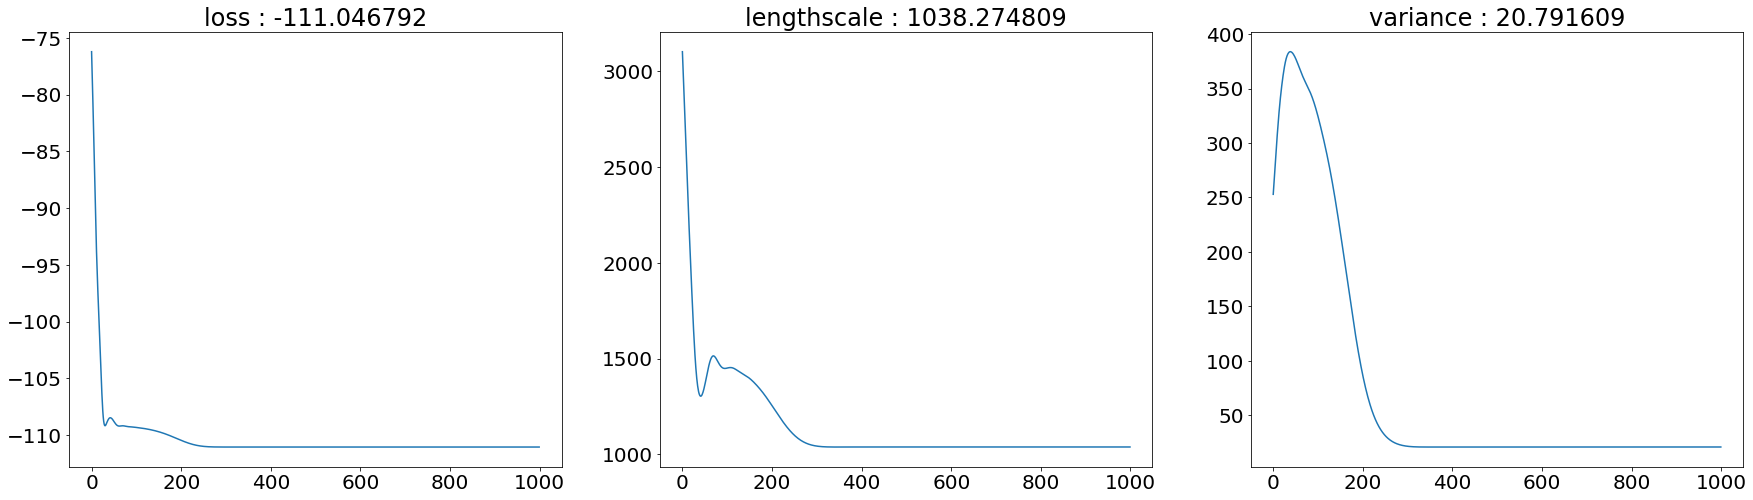

In [10]:
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = gp.kernels.RBF(input_dim=1,variance=torch.tensor(1.),lengthscale=torch.tensor(500.))
#set prior distribution for kernels
RBF_kernel.set_prior("variance", dist.Uniform(torch.tensor(1.), torch.tensor(500.)))
RBF_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1.), torch.tensor(5000.)))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.GPRegression_V(X, y, RBF_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.SVI_NI_optm(gpr,x_sigma,num_iteration=1000)

axes = PSTHM.plot_track_list(track_list)

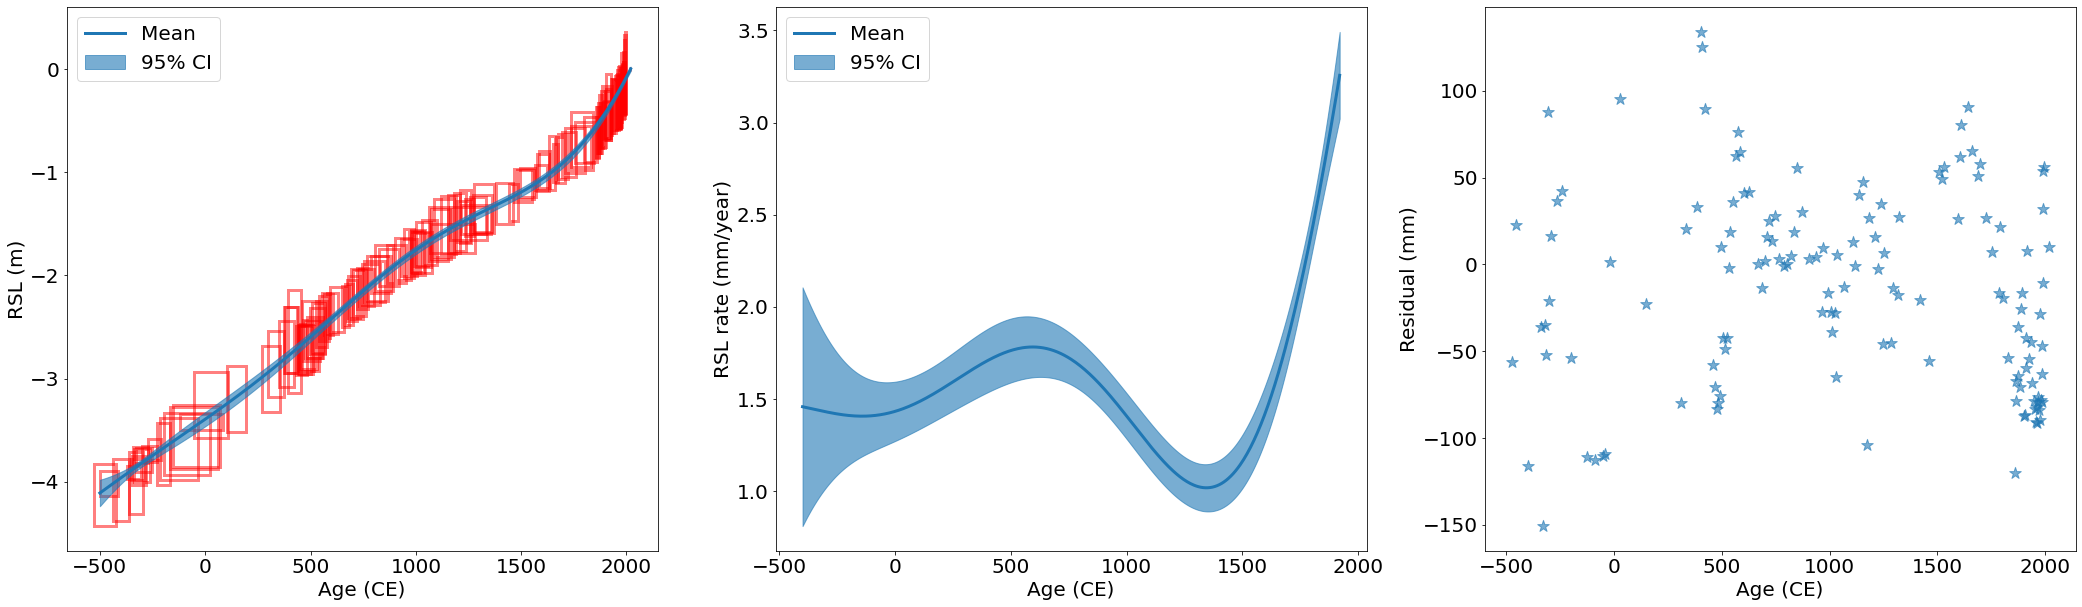

In [11]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5)
c_kernel_y_mean, c_kernel_y_var = gpr(x_test.double(), full_cov=True)
c_kernel_sd = torch.diag(c_kernel_y_var).sqrt()  # standard deviation at each input point x
rsl_time,c_kernel_rsl_rate,c_kernel_rsl_rate_sd = PSTHM.cal_rate_var(x_test.detach().numpy(),c_kernel_y_var.detach().numpy(),c_kernel_y_mean.detach().numpy())

axes = PSTHM.plot_tem_regression(X,y,x_sigma,y_sigma,x_test,c_kernel_y_mean,c_kernel_sd,
                          rsl_time,c_kernel_rsl_rate,c_kernel_rsl_rate_sd)

Thanks to the nonparametric nature of GP, we can now start to infer continuous sea-level change pattern and rate. If we check the sea-level change rate, we can see that it generally agrees well with the change-point results that the rate here reduces a bit before 1000 CE and start to rise between 1500 and 1800, but now we have a continuous estimate of sea-level change rate. 

### 5. Physical model
Unlike all statistical models mentioned above, physical modelling is a way of modeling and simulating systems that consist of real physical components. For paleo sea-level studies, a commonly-used physical model is glacial isostatic adjustment (GIA) model, which solves the so-called sea-level equation ([Farrel and Clark 1976](https://academic.oup.com/gji/article/46/3/647/608502?login=true)) to calculate the sea-level change caused by ice-ocean mass exchange induced gravitaitonal, rotational and deformational variation. You can read this review article by [Whitehouse 2018](https://esurf.copernicus.org/articles/6/401/2018/) to get further insights into GIA modelling. The reason why we use physical model is it will provide insights into locations where no data or very few RSL data existed, like Antarctica. Physics model can also track some tele-connected signals like [sea-level fingerprint](https://climate.nasa.gov/news/2626/evidence-of-sea-level-fingerprints/). Hence physical model is an important tool to understand sea-level variability.  

For GIA modelling, the major uncertaintis are ice history and Earth rheology parameters, which can be constrained by sea-level data in the same way as statistical parameters we mentioned above. We can write a single GIA model as:
$$
f_{GIA}(x,t) = GIA(x,t | i, e)  
$$
where $GIA(x,t|i,e)$ indicates GIA modelling results of spaito-temporal sea-level variation given a single ice history parameter (i) and Earth rheological parameter (e). Constraining $i$ and $e$ for a GIA model is very challenging and usually a multi-disciplinary tasks that involves ice geomorphology and solid Earth physics, hence, instead of using a single ice or Earth rheological parameter, sea-level studies usually perform ensemble analysis over large number of ice parameters ($I$) and Earth rheological parameters ($E$) to find a best-fit parameter set ($\hat{i},\hat{e}$) to generate sea-level prediction:
$$
f_{GIA}(x,t) = GIA(x,t | \hat{i},\hat{e})
$$ 

Alternatively, another way to predict sea-level is performing weigted sum of different parameter sets:
$$
f_{GIA}(x,t) = \sum_{p=1}^{n}w_{p}GIA(x,t| I_{p},E_{p})
$$
where $w{_p}$ indicates weighted parameters for each physical model set and $n$ denotes the number of tested physical parameters. Unlike statistical parameters that can be sampled easliy from a continuous distribution, physics models are computationally more expensive to run, so the the prior distribution of physical parameters are often discrete (c.f., continuous). For example, the following table showing prior distribution for Earth parameter in [Lin et al., 2023](https://www.sciencedirect.com/science/article/pii/S0012821X23000791) used discrete uniform distributions for a specific type of Earth rheological parameters consisting solid Earth into three parameters: lithosphereic thickness, upper mantle and lower mantle viscosities.

<img width=1200px src="model parameter.png"/>

To illustrate, let's look some GIA modelling results using [ICE6G_C](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014JB011176) ice model with 96 km lithosphere, 20 x $10^{21}$ Pa s lower mantle viscosity and a series of upper mantle viscosity shown below. To simplified this problem a bit, here we assume for the last 3000 years, GIA model predicts a single value for sea-level change rate. Let's check the model outputs:

| Model | Upper mantle viscosity ($10^{21}$ Pa s)  | RSL rate (mm/yr) |
|  :---:|  :---:  |    :---: |
| GIA model 1  | 0.05      |    -0.74|
| GIA model 2  | 0.08      |    0.47 |
| GIA model 3  | 0.1       |    0.89 |
| GIA model 4  | 0.3       |    2.16 |
| GIA model 5  | 0.5       |    2.14 |
| GIA model 6  | 0.8       |    1.98 |
| GIA model 7  | 1       |    1.87 |
| GIA model 8  | 3       |    0.61 |
| GIA model 9  | 5       |    0.09 |




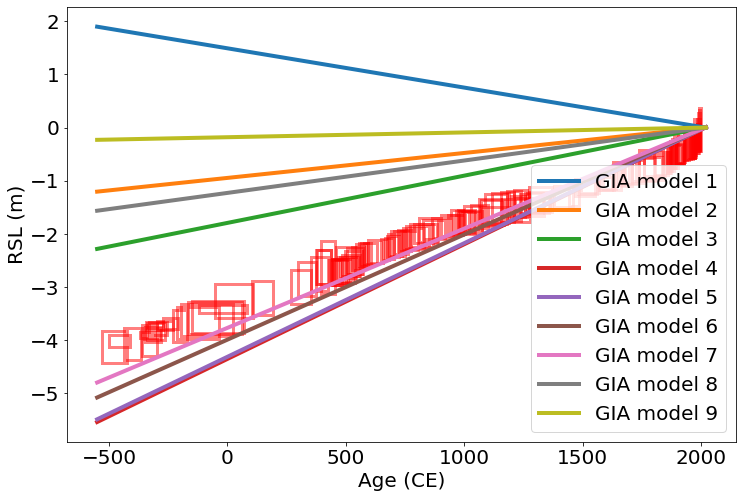

In [12]:
forward_x = torch.tensor([-550,2020])

GIA_1 = (forward_x-2017)*-0.00074
GIA_2 = (forward_x-2017)*0.00047
GIA_3 = (forward_x-2017)*0.00089
GIA_4 = (forward_x-2017)*0.00216
GIA_5 = (forward_x-2017)*0.00214
GIA_6 = (forward_x-2017)*0.00198
GIA_7 = (forward_x-2017)*0.00187
GIA_8 = (forward_x-2017)*0.00061
GIA_9 = (forward_x-2017)*0.00009

GIA_ensemble = torch.stack([GIA_1,GIA_2,GIA_3,GIA_4,GIA_5,GIA_6,GIA_7,GIA_8,GIA_9])
#visulize GIA model results
plt.figure(figsize=(12,8))
ax = plt.subplot(111)
PSTHM.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,ax=ax)
for i in range(0,9):

    plt.plot(forward_x,GIA_ensemble[i],linewidth=4,label=f'GIA model {i+1}')

plt.legend(loc='lower right');


If we do a model-data comparison, we can find out that model 7 fits data the best, so we can just use model 7 for global sea-level prediction. But it turns out that the model 7 performance it not satisfied enough, so we can try to do weighted sum of different physical models. To do this, as before, we need to assign a prior distribution for weighting parameters:
$$
w_{p} \sim Dir(1)
$$
where $Dir$ indicates a a Dirichlet distribution, which is used to generate random weighting factors that fulfil the conditions $\sum_{p=1}^{n} w_{p} = 1$ and $w_{p} >0$; 1 is a hyperparameter that describes the concentration of random samples. Note, to ensure this model works well, the time range GIA model covers should be larger than the RSL data age. 

  0%|          | 0/1000 [00:00<?, ?it/s]

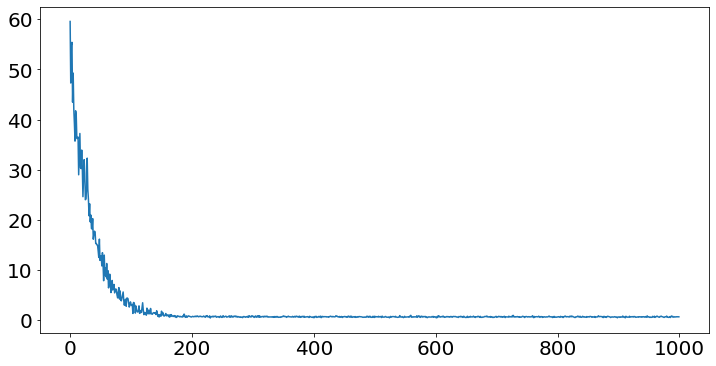

In [13]:
import pyro.distributions as dist

#------Define the process mdoel---------
GIA_ensemble_model =  PSTHM.ensemble_GIA_model
test_X = X[:,None] #convert X to a 2D array which is more common for pytorch models

#-------Define parameter model---------
alpha_prior = dist.Uniform(0.01,100)  #prior distribution for b

#-------Infer posterior distribution--------
guide,losses = PSTHM.opti_pyro_model(GIA_ensemble_model,test_X,y,x_sigma,y_sigma,GIA_ensemble,forward_x,lr = 0.01,number_of_steps=1000)
plt.plot(losses)

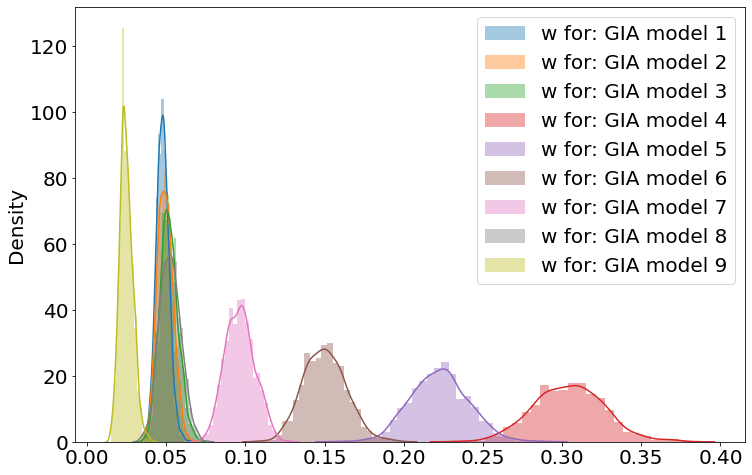

In [14]:
#predict posterior distribution
num_pred = 1000
w_stores = np.zeros((num_pred,GIA_ensemble.shape[0]))
alpha_stores = np.zeros(num_pred)
posterior_GIA = np.zeros((num_pred,len(forward_x)))
for i in range(1000):
    test_sample = guide()
    w_store =test_sample['W'].detach().numpy()
    posterior_GIA[i] = np.sum( GIA_ensemble.detach().numpy() *w_store[:,None],axis=0)
    w_stores[i] = w_store

#------plot posterior distribution of w and alpha------
plt.figure(figsize=(12,8))

for i in range(GIA_ensemble.shape[0]):
    sns.distplot(w_stores[:,i],label=f'w for: GIA model {i+1}')
plt.legend();

It is clear that GIA models 4, 5, 6, 7 present larger weighting parameter ($w$) compared with others because they fits data better than others (see GIA model figure above). We can interpret this weighting facotr as: there is a 30% +/- 6% chance that the tested latent variable (upper mantle viscosity) is the parameter represented by GIA model 4 (0.3 x $10^{21}$ Pa s). 

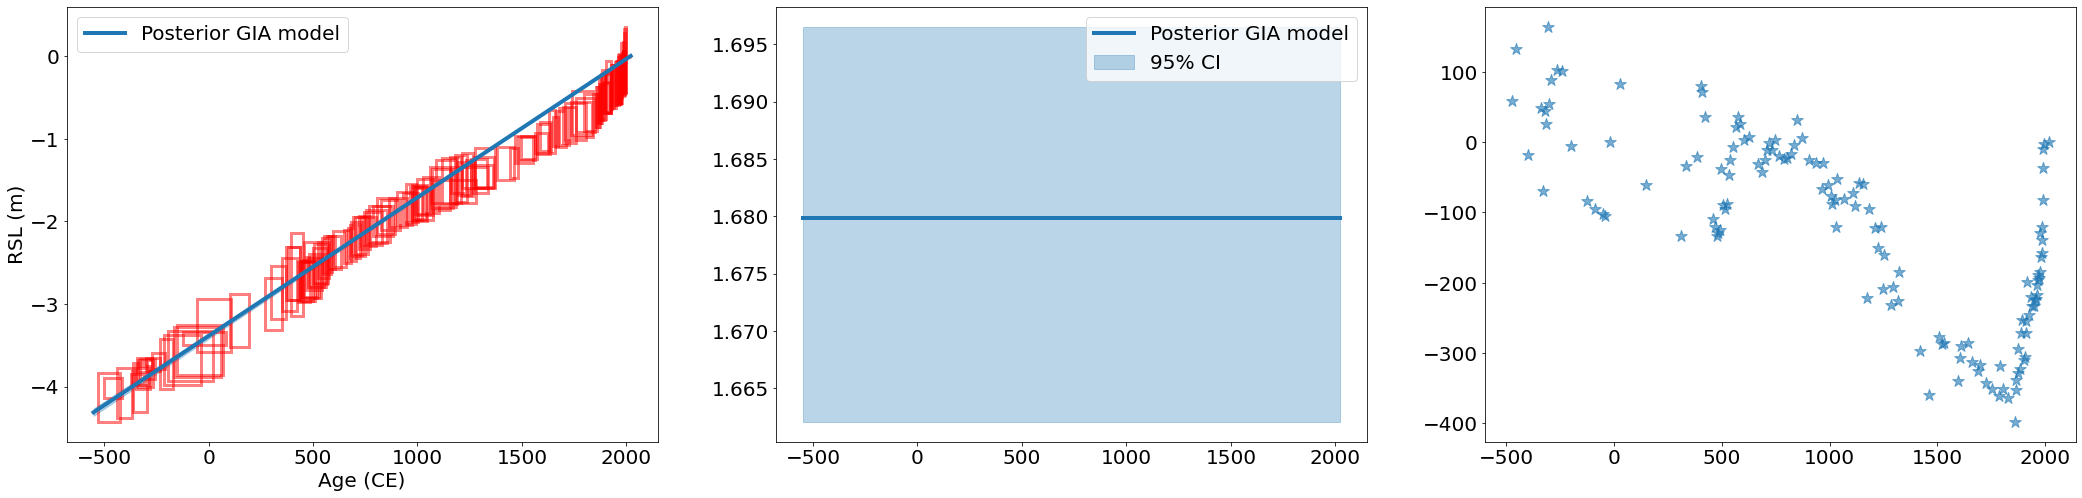

In [15]:
plt.figure(figsize=(36,8))
ax = plt.subplot(131)
PSTHM.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,ax=ax)
pred_2p5,pred50,pred_97p5 = np.percentile(posterior_GIA,[2.5,50,97.5],axis=0)
plt.plot(forward_x,pred50,color='C0',linewidth=4,label='Posterior GIA model')
plt.fill_between(forward_x,pred_2p5,pred_97p5,color='C0',alpha=0.3)
plt.legend()

plt.subplot(132)
posterior_rate50 = np.diff(pred50)/np.diff(forward_x) *1000
posterior_rate2p5 = np.diff(pred_2p5)/np.diff(forward_x) *1000
posterior_rate97p5 = np.diff(pred_97p5)/np.diff(forward_x) *1000
plt.plot(forward_x,[posterior_rate50,posterior_rate50],color='C0',linewidth=4,label='Posterior GIA model')
plt.fill_between(forward_x,[posterior_rate2p5[0],posterior_rate2p5[0]],np.array([posterior_rate97p5[0],posterior_rate97p5[0]]),color='C0',alpha=0.3,label='95% CI')
plt.legend()

plt.subplot(133)
f_posterior = interpolate.interp1d(forward_x,pred50)
posterior_pred = f_posterior(X)
plt.scatter(X,(y.detach().numpy()-posterior_pred)*1000,s=150,marker='*',color='C0',alpha=0.6,label = 'Change-point model')

You might find the results here is pretty similar to a linear model, making it seems meaningless to do a GIA model ensemble anlaysis, but it will become very important when we incorporate spatial analysis, you can check sptiao-temporal Gaussian Process tutorial for more details!

### 6. Mixed physical and statistical model or data assimilation
Lastly, instead of statistis-only or physical-only model, we can use a mixture of statiscal and physical model. The reason why we want to do that is a physical model is always an imperfect representation of the real world, in that case, there are always some missing physical phenomenon that did not included in the physical model. For example, a GIA model does not consider RSL change caused by sediment compaction and sterodynamic effects, which can be a significant sea-level change factor in some locations. Therefore, using statical model to infer those signal can be a very good supplementary for phycics model. 

There are many way to implement such mixed physical and statistical model, here we provide an example with Gaussian Process model. Recall in Gussian Process model mentioned above, we use a 0 mean for $\mu(t)$, and instead of doing that, we can use GIA model for the mean function such:
$$
\mu(t) = f_{GIA}(t)
$$
and so the Gaussian Process model becomes:
$$
f_{GP} \sim GP(f_{GIA}(t),K_{RBF}(t,t'))
$$
this is so-called 'incorporating eplicit basis function' in section 2.7 Raumussen's [book about Gaussian Process](https://gaussianprocess.org/gpml/chapters/RW.pdf). 



  0%|          | 0/1000 [00:00<?, ?it/s]

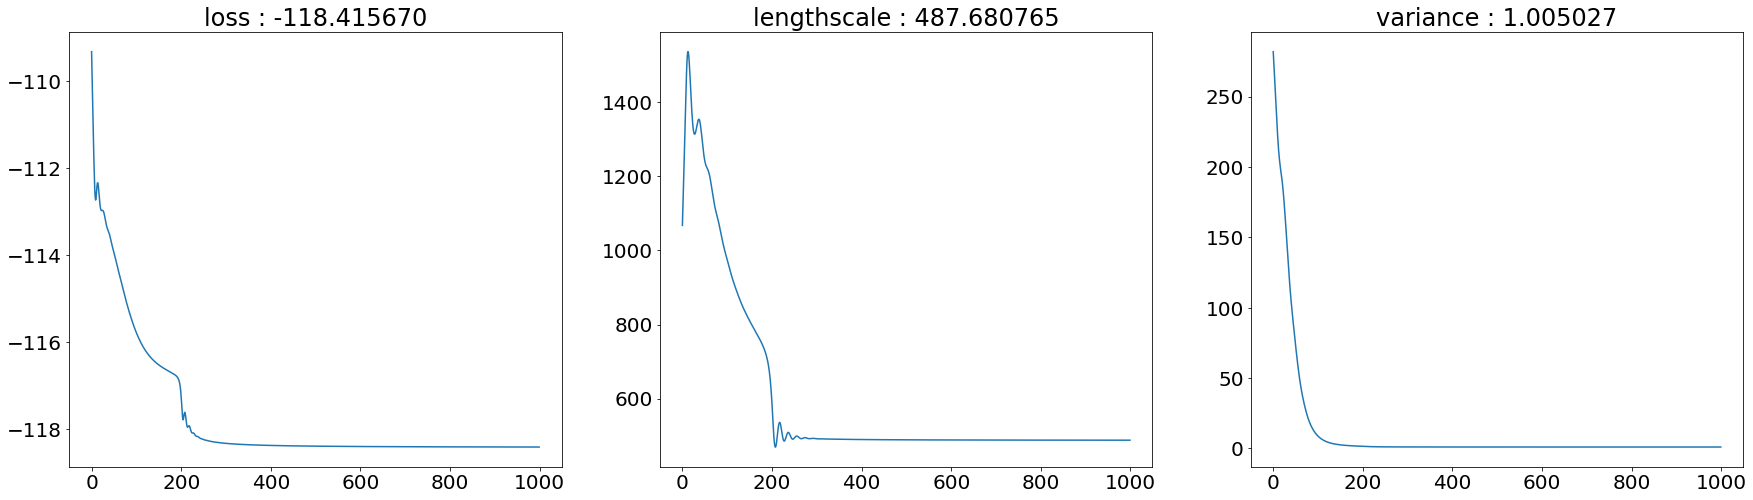

In [16]:
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = gp.kernels.RBF(input_dim=1,variance=torch.tensor(1.),lengthscale=torch.tensor(500.))
#set prior distribution for kernels
RBF_kernel.set_prior("variance", dist.Uniform(torch.tensor(1.), torch.tensor(500.)))
RBF_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1.), torch.tensor(5000.)))

f_posterior = interpolate.interp1d(forward_x,pred50)
posterior_pred = f_posterior(X)

y_residual = y -posterior_pred 
#generate a GP gression model conditioned on RSL data
gpr = PSTHM.GPRegression_V(X, y_residual, RBF_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.SVI_NI_optm(gpr,x_sigma,num_iteration=1000)

axes = PSTHM.plot_track_list(track_list)

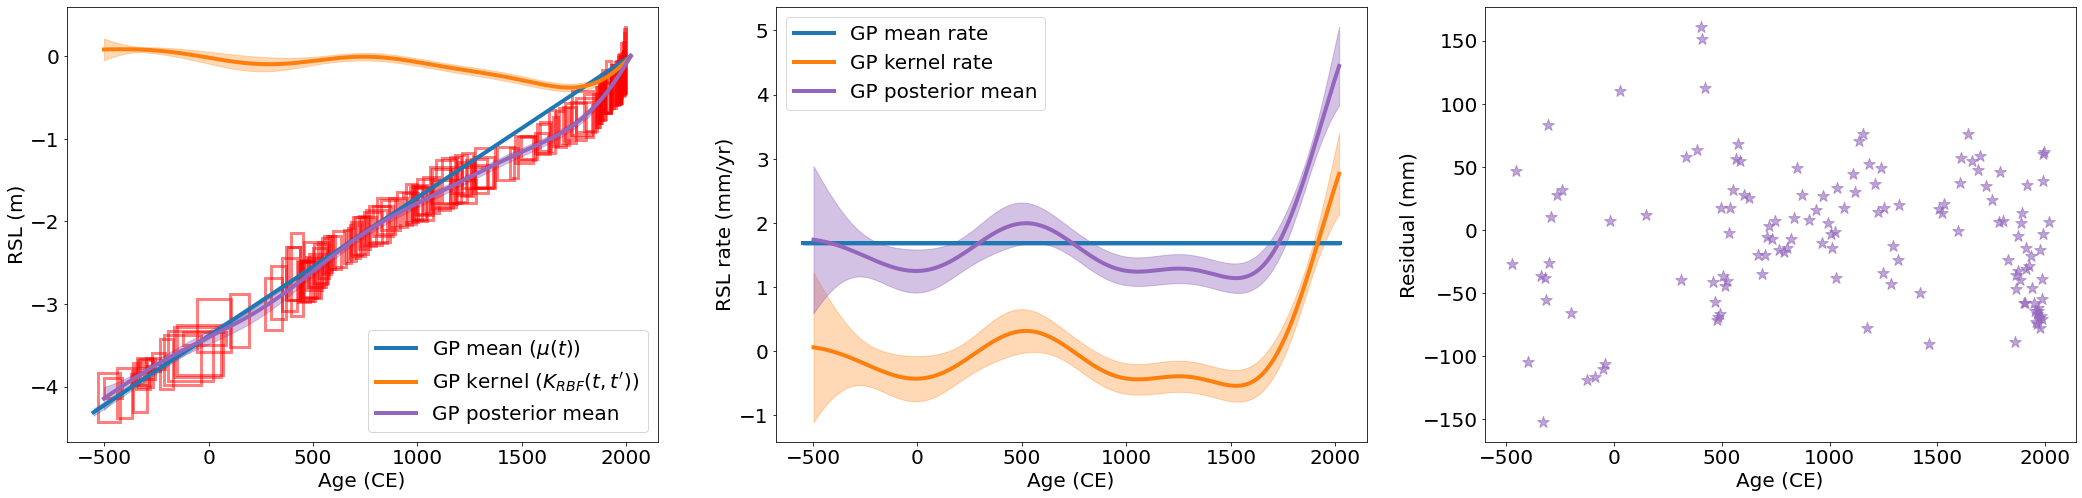

In [17]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5)
c_kernel_y_mean, c_kernel_y_var = gpr(x_test.double(), full_cov=True)
gia_pred = f_posterior(x_test)
c_kernel_sd = torch.diag(c_kernel_y_var).sqrt()  # standard deviation at each input point x
rsl_time,c_kernel_rsl_rate,c_kernel_rsl_rate_sd = PSTHM.cal_rate_var(x_test.detach().numpy(),c_kernel_y_var.detach().numpy(),c_kernel_y_mean.detach().numpy(),difftimestep=5)
f_GIA_sd = interpolate.interp1d(forward_x,(pred_97p5-pred50)/2)
GIA_sd = f_GIA_sd(x_test)
combined_mean = c_kernel_y_mean.detach().numpy()+gia_pred
combined_sd = (GIA_sd**2+c_kernel_sd.detach().numpy()**2)**0.5
GIA_rate_sd = (posterior_rate50-posterior_rate97p5)/2
rate_sd_combined = ((GIA_rate_sd/1000)**2+c_kernel_rsl_rate_sd**2)**0.5

plt.figure(figsize=(36,8))
ax = plt.subplot(131)
PSTHM.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,ax=ax)
plt.plot(forward_x,pred50,color='C0',linewidth=4,label='GP mean ($\mu(t)$)')
plt.fill_between(forward_x,pred_2p5,pred_97p5,color='C0',alpha=0.3)
plt.plot(x_test,c_kernel_y_mean.detach().numpy(),color='C1',linewidth=4,label="GP kernel ($K_{RBF}(t,t')$)")
plt.fill_between(x_test,(c_kernel_y_mean-2*c_kernel_sd).detach().numpy(),(c_kernel_y_mean+2*c_kernel_sd).detach().numpy(),color='C1',alpha=0.3)
plt.plot(x_test,combined_mean,color='C4',linewidth=4,label='GP posterior mean')
plt.fill_between(x_test,combined_mean-2*combined_sd,combined_mean+2*combined_sd,color='C4',alpha=0.4)
plt.legend(loc=0)

ax2 = plt.subplot(132)
plt.plot(forward_x,[posterior_rate50,posterior_rate50],color='C0',linewidth=4,label='GP mean rate')
plt.fill_between(forward_x,[posterior_rate2p5[0],posterior_rate2p5[0]],np.array([posterior_rate97p5[0],posterior_rate97p5[0]]),color='C0',alpha=0.3)
plt.plot(rsl_time,c_kernel_rsl_rate*1000,color='C1',linewidth=4,label='GP kernel rate')
plt.fill_between(rsl_time,(c_kernel_rsl_rate-2*c_kernel_rsl_rate_sd)*1000,(c_kernel_rsl_rate+2*c_kernel_rsl_rate_sd)*1000,color='C1',alpha=0.3)
plt.plot(rsl_time,c_kernel_rsl_rate*1000+posterior_rate50,color='C4',linewidth=4,label='GP posterior mean')
plt.fill_between(rsl_time,(c_kernel_rsl_rate-2*rate_sd_combined)*1000+posterior_rate2p5,(c_kernel_rsl_rate+2*rate_sd_combined)*1000+posterior_rate97p5,color='C4',alpha=0.4)
plt.legend(loc=0)
plt.xlabel('Age (CE)')
plt.ylabel('RSL rate (mm/yr)')

ax2 = plt.subplot(133)
f_combined_rsl = interpolate.interp1d(x_test,combined_mean)
plt.scatter(X,(y.detach().numpy()-f_combined_rsl(X))*1000,s=150,marker='*',color='C4',alpha=0.6,label = 'GP posterior')
plt.xlabel('Age (CE)')
plt.ylabel('Residual (mm)');

It can be seen that the results here are very similar to RBF kernel with 0 mean, which is related to over-simplification of GIA model output here (which is usually non-linear). But the key idea here is that we use a physical model as the mean function for GP and use GP kernel to infer the temporal variation of un-modelling physical process. Here we might tell that rapid RSL rise in New Jersey is not related to GIA-induced sea-level change, instead, it is due to other physical processes, perhaps sterodynamic sea-level rise due to recent global warming. 

Ok! I hope you are familiar with process level modelling and using different process model to infer different properties. In the next tutorial, we go through analysis level of models, which you may have some ideas from this tutorial. For example, the hand-drawn mdoel is a deterministic model with an exact value without uncertainty estimate, and most of the models we used here is a Bayesian model that represent each parameter as a random variable. You will find more about this in the next tutorial.

Thanks for going through this tutorial, we are actively developing PaleoSTeHM now, so your feedback will be truely valueable to us. You can fill this [survey](https://forms.gle/W1DMPQY8KyAgoT9r6) to let us know what do you think about this tutorial, which will shape the future direction of PaleoSTeHM.